In [2]:
import os
import pandas as pd
import numpy as np
# configure file path
#data_path = os.path.join(os.environ['DATA_PATH'], 'MovieLens')
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'
# read data
df_movies = pd.read_csv((movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv((ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix
pp_mat = df_movie_features.to_numpy()
mat_movie_features = csr_matrix(df_movie_features.values)

In [4]:
df_movie_features

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print(pp_mat)

[[4.  0.  0.  ... 2.5 3.  5. ]
 [0.  0.  0.  ... 2.  0.  0. ]
 [4.  0.  0.  ... 2.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


In [6]:
np.savetxt("input.txt", np.array(pp_mat), fmt="%s")

In [7]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


Text(0, 0.5, 'number of ratings')

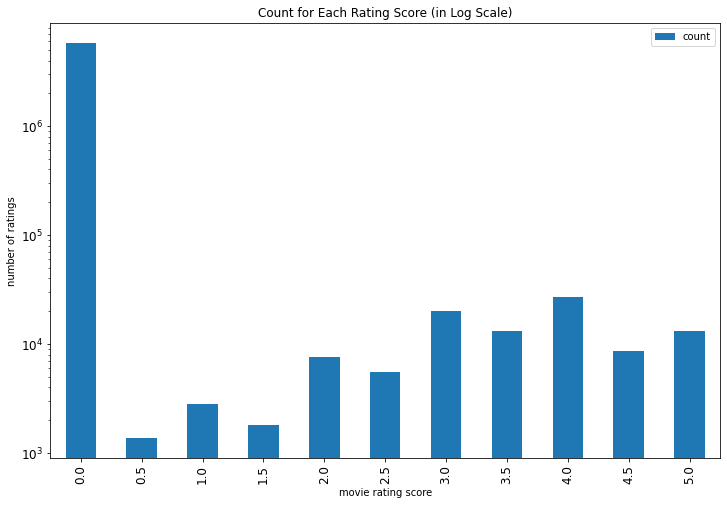

In [8]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [9]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

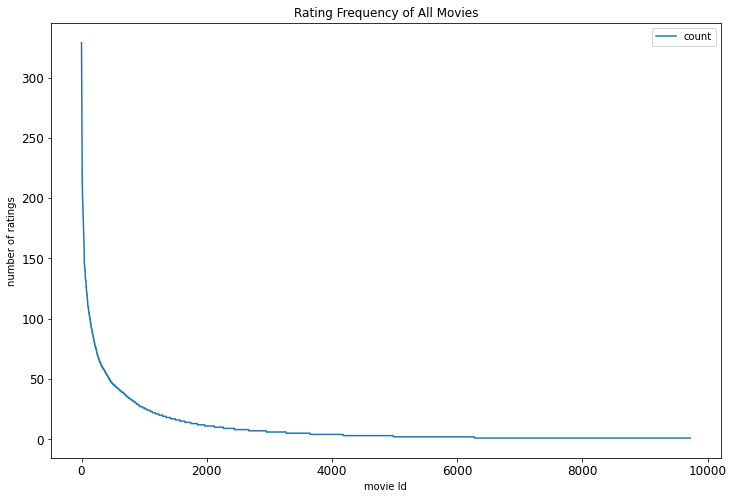

In [10]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

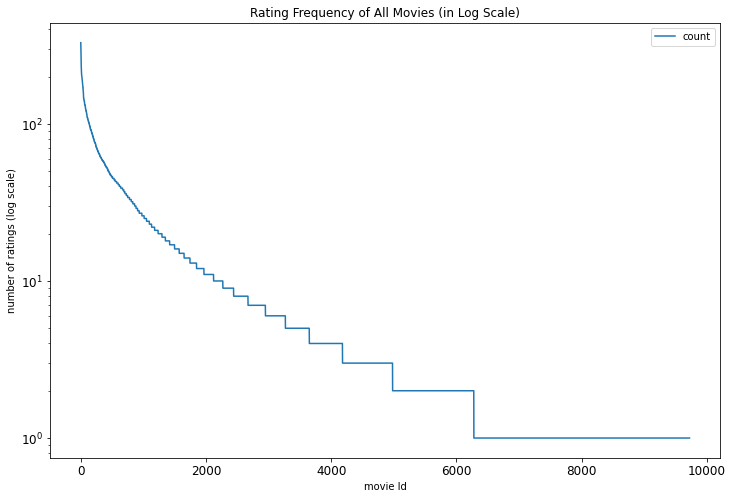

In [11]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [12]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))


1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [13]:

# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (41360, 3)


In [14]:

# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


Text(0, 0.5, 'number of ratings')

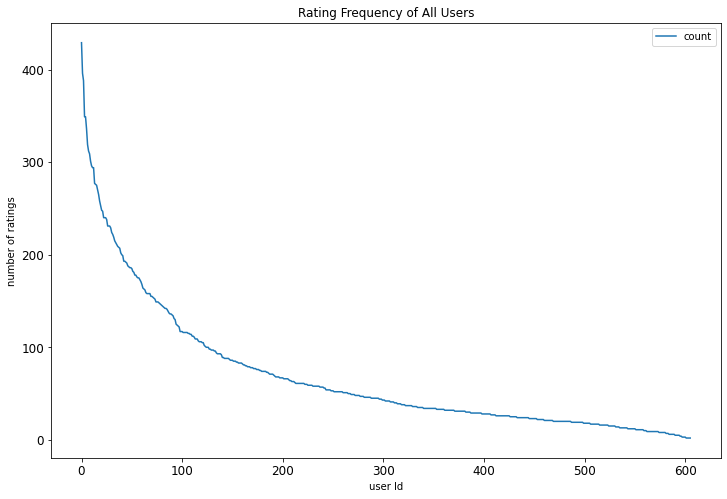

In [15]:

# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [16]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))


1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64

In [17]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 3)


In [27]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    i:movie for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
pp_mat_new = movie_user_mat.to_numpy()

In [19]:
np.savetxt("matrix1.txt", np.array(pp_mat_new), fmt="%s")

In [40]:
pp_mat_new

array([[4. , 0. , 0. , ..., 4. , 2.5, 5. ],
       [0. , 0. , 4. , ..., 0. , 2. , 0. ],
       [4. , 0. , 5. , ..., 0. , 2. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 4.5],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 3. ]], dtype=float32)

In [41]:
pp_mat_new_t = pp_mat_new.transpose()

In [42]:
np.shape(pp_mat_new_t)

(268, 450)

In [43]:
np.savetxt("ratings.txt", np.array(pp_mat_new_t), fmt="%s")

In [29]:
movie_to_idx

{0: 'Toy Story (1995)',
 1: 'Jumanji (1995)',
 2: 'Grumpier Old Men (1995)',
 3: 'Heat (1995)',
 4: 'Sabrina (1995)',
 5: 'GoldenEye (1995)',
 6: 'American President, The (1995)',
 7: 'Casino (1995)',
 8: 'Sense and Sensibility (1995)',
 9: 'Ace Ventura: When Nature Calls (1995)',
 10: 'Get Shorty (1995)',
 11: 'Leaving Las Vegas (1995)',
 12: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 13: 'Babe (1995)',
 14: 'Dead Man Walking (1995)',
 15: 'Clueless (1995)',
 16: 'Seven (a.k.a. Se7en) (1995)',
 17: 'Pocahontas (1995)',
 18: 'Usual Suspects, The (1995)',
 19: "Mr. Holland's Opus (1995)",
 20: 'From Dusk Till Dawn (1996)',
 21: 'Broken Arrow (1996)',
 22: 'Happy Gilmore (1996)',
 23: 'Braveheart (1995)',
 24: 'Taxi Driver (1976)',
 25: 'Birdcage, The (1996)',
 26: 'Bad Boys (1995)',
 27: 'Apollo 13 (1995)',
 28: 'Batman Forever (1995)',
 29: 'Casper (1995)',
 30: 'Congo (1995)',
 31: 'Crimson Tide (1995)',
 32: 'Desperado (1995)',
 33: 'Die Hard: With a Vengeance (1995)',
 34: 'First

In [30]:
type(movie_to_idx)

dict

In [32]:
df_movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [33]:
movie_arr = df_movies.set_index('movieId').loc[movie_user_mat.index].title

In [34]:
movie_arr

movieId
1                         Toy Story (1995)
2                           Jumanji (1995)
3                  Grumpier Old Men (1995)
6                              Heat (1995)
7                           Sabrina (1995)
                        ...               
109374    Grand Budapest Hotel, The (2014)
109487                 Interstellar (2014)
112852      Guardians of the Galaxy (2014)
116797           The Imitation Game (2014)
122904                     Deadpool (2016)
Name: title, Length: 450, dtype: object

In [35]:
type(movie_arr)

pandas.core.series.Series

In [37]:
movie_arr = movie_arr.to_numpy()

In [38]:
type(movie_arr)

numpy.ndarray

In [39]:
np.savetxt("movies.txt", np.array(movie_arr), fmt="%s")